# Titanic survival prediction with XGBoost

In this document I will show you how to use SHAP (SHapley Additive exPlanations) to explain each prediction of a complex model. 

SHAP explains the output of any machine learning model using expectations and Shapley values. SHAP unifies aspects of several previous methods and represents the only possible consistent and locally accurate additive feature attribution method based on expectations.

For details about SHAP, see the [SHAP paper](https://arxiv.org/abs/1705.07874).

I will use here the oficial implementation, which you can find in the [Github repo](https://github.com/slundberg/shap).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import seaborn

shap.initjs()

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 6)

Populating the interactive namespace from numpy and matplotlib


## Load and clean dataset

Let's load the training and test set:

In [3]:
# Read in the data
train = pd.read_csv("../../data/titanic/train.csv")
test = pd.read_csv("../../data/titanic/test.csv")

Now we remove useless or too complex features:

In [4]:
train = train.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin"])
test  = test.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin"])

Create one-hot encoding for categorycal features:

In [5]:
train = pd.get_dummies(train, columns = ["Pclass", "Embarked"], drop_first = False)
test = pd.get_dummies(test, columns = ["Pclass", "Embarked"], drop_first = False)

train.Sex = train.Sex.apply(func = lambda x: int(x == "male"))
test.Sex = test.Sex.apply(func = lambda x: int(x == "male"))

In [6]:
train.head(3)

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1,0,0,1


## Train the XGBoost model

Let's now train the XGBoost model. We already now the best parameters (from the CV implementation):

In [7]:
xgb_train = xgb.DMatrix(train.drop(columns="Survived").values, train.loc[:, "Survived"].values)
xgb_test  = xgb.DMatrix(test.values)

In [8]:
params = {
    "eta": 0.2,
    "max_depth": 7,
    "objective": "binary:logistic",
    "silent": 1,
    "eval_metric": "error"
}

model = xgb.train(params, xgb_train, 22)

## Explain the XGBoost model

Because the Tree SHAP algorithm is implemented in XGBoost we can compute exact SHAP values quickly over thousands of samples. So let's explain every prediction in the test set:

In [9]:
# compute the SHAP values for every prediction in the validation dataset
shap_values = model.predict(xgb_test, pred_contribs = True)

In [10]:
shap_values.shape

(418, 12)

The SHAP values matrix contains 12 columns and 418 rows. Each row corresponds to a row in the test set. The first 11 columns correspond to the SHAP value of each feature for each prediction in the test set. The last column corresponds to the bias of the model.

### Explain a single passenger's chances of surviving

SHAP values sum to the difference between the expected output of the model and the current output for the current passenger. Note that for the Tree SHAP implemementation the margin output of the model is explained, not the trasformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Features that contribute to survival point to the right. Features that contribute to death point to the left.

In [11]:
shap.visualize(shap_values = shap_values[0,:], feature_names = test.columns, features = test.iloc[0,:])

/usr/local/lib/python3.5/dist-packages/shap/plots.py:471: UserWarning: the visualize() function has been renamed to 'force_plot' for consistency
  warnings.warn("the visualize() function has been renamed to 'force_plot' for consistency")


As you can see, the Pclass feature is splitted. But we can change the shap_values variable to sum the effect of all Pclass-related features (and Embarked-related features):

In [12]:
join_shap_values = np.zeros(shape = (shap_values.shape[0], 7))
join_shap_values[:, :5] = shap_values[:, :5]
join_shap_values[:, 5] = shap_values[:, 5:8].sum(axis = 1)
join_shap_values[:, 6] = shap_values[:, 8:11].sum(axis = 1)

In [13]:
feature_names = list(test.columns.values[:5])
feature_names.append("Pclass")
feature_names.append("Embarked")

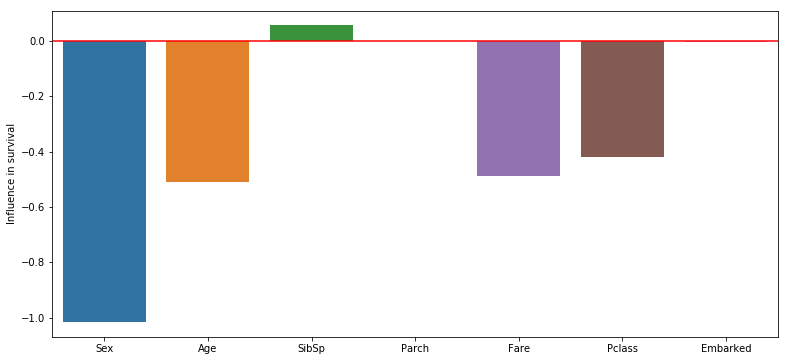

In [14]:
seaborn.barplot(feature_names, join_shap_values[0,:]);
plt.axhline(y = 0, color = "red");
plt.ylabel("Influence in survival");

### Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the log odds prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature on a row, where the x-axis is the SHAP value (which for this model is in units of log odds of winning). By doing this for all features, we see which features drive the model's prediction a lot, and which only affect the prediction a little.

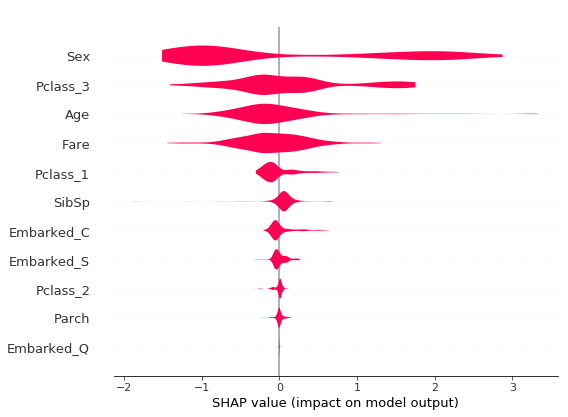

In [15]:
shap.summary_plot(shap_values, test.columns, plot_type="violin")

## Examine how changes in a feature change the model's prediction

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of feature for all passengers we can see how changes in the feature's value affect the model's output. Note that these plots are very similar to standard Partial Dependence Plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms affect the importance of a feature is capture by the vertical dispersion of the data points. 

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of surviving by 4, while a value of +2 means observing that feature raises your log odds of surviving by 2. 

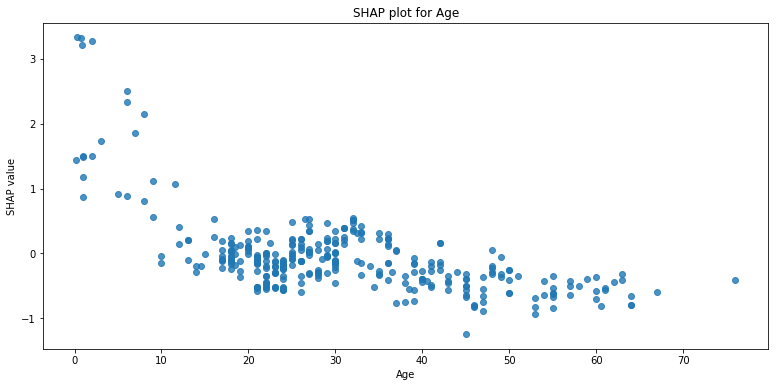

In [16]:
# Make a SHAP plot for Age
seaborn.regplot(x = test.Age, y = shap_values[:,1], fit_reg = False);
plt.ylabel("SHAP value");
plt.title("SHAP plot for Age");

The result is the expected one. Children survive, old people die.

What about other variables?

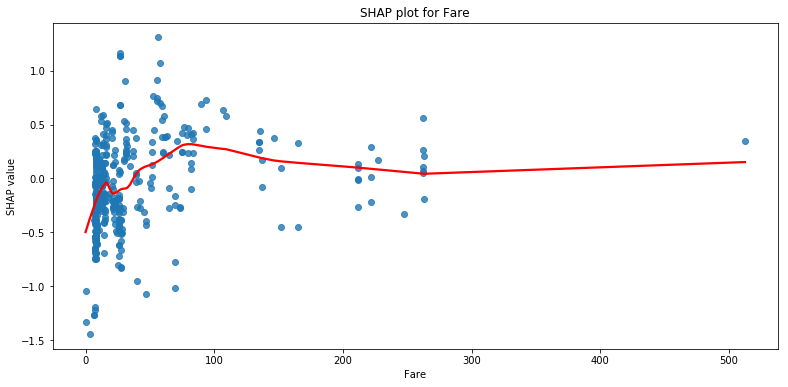

In [17]:
# Make a SHAP plot for Fare
seaborn.regplot(x = test.Fare, y = shap_values[:,4], fit_reg = True, lowess = True, line_kws={"color":"red"});
plt.ylabel("SHAP value");
plt.title("SHAP plot for Fare");

The Fare has some influence in the low range (the more you pay, the more you survive). We don't have enough data to see what happens in the high range. But we can create artificial data!!

In [18]:
high_fare_test = test.append(test, ignore_index=True)
nrows = high_fare_test.shape[0]
high_fare_test.Fare = np.random.uniform(low = 0, high = 500, 
                                        size = 836)

xgb_high_fare_test = xgb.DMatrix(data = high_fare_test.values)
shap_values_high_fare = model.predict(xgb_high_fare_test, pred_contribs = True)

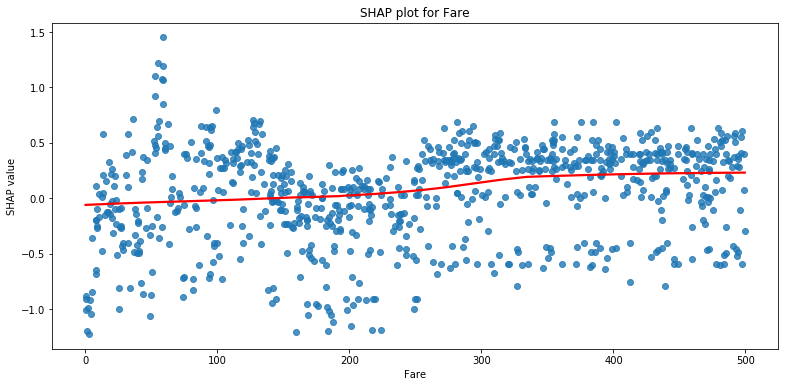

In [19]:
# Make a SHAP plot for Fare
seaborn.regplot(x = high_fare_test.Fare, 
                y = shap_values_high_fare[:,4], 
                fit_reg = True, 
                lowess = True, 
                line_kws={"color":"red"});
plt.ylabel("SHAP value");
plt.title("SHAP plot for Fare");

The problem here is that our artificial data is... well, artificial :)
This means that the Fare feature may not follow the typical distribution we find in the real dataset (Pclass = 1 people probably pay more for the ticket than others, but we are not considering this kind of constraints).